In [12]:
# This data will become available after publication

# imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys

# Add the project root to Python path dynamically
# This finds the project root by looking for setup.py
current_dir = Path.cwd()
project_root = None

# Look for setup.py starting from current directory and going up
for parent in [current_dir] + list(current_dir.parents):
    if (parent / "setup.py").exists():
        project_root = parent
        break

if project_root is None:
    # Fallback: assume we're in src/example_files and go up 2 levels
    project_root = Path(__file__).parent.parent.parent if '__file__' in globals() else current_dir.parent.parent

sys.path.insert(0, str(project_root))

# Now we can import from src
from src.core_functionality.data_processing import DataProcessingCSV
from src.core_functionality.spectrum import Spectrum, Spectra
from src.core_functionality.baseline_correction import ARPLS
from src.core_functionality.chemometrics import Chemometrics, FIT_PARAMETERS, CONFIDENCE_INTERVALS
from src.core_functionality.phase import Phase
from src.core_functionality.rate_data import RateData

print(f"All imports successful! Project root: {project_root}")

All imports successful! Project root: c:\Users\alw7s\Git\PyMESpec


In [13]:
# Details of this Tutorial:
# This data comes from a modulation excitation UV-vis experiment on V2O5 / TiO2.
# The reaction is propane oxidative dehydrogenation (ODH) with periodic switching of O2.
# Data is collected every 1 s, with a pulse period of 60 s.
# The first 30 s of each pulse is O2 off, the last 30 s is O2 on. Propane is on the whole time.
# There are 10 pulses in total for a total of 600 s of data.



In [14]:
# Reading in data from CSV files
# Here is the path to the main set of the spectra
path = project_root / "src" / "example_files" / "MES_400C_C3_ODH_O2_Switching" / "Processed_Samples"

# Hints:
# 1. You need to check what the columns of the csv files headers are.
# 2. The reference spectra and the main data may have different frequency ranges (spectral coordinates) you must make sure they match.
# 3. Pay attention to the to the number of data points per pulse and the total number of pulses.


# Names of the CSV columns to read
csv_frequency_column = "frequency"
csv_intensity_column = "intensity"
# The initial and final rows to investigate (-1 means the last row with data)
csv_row_num_start = 0
csv_row_num_end = -1
# The spectral coordinate range to investigate (the subset of frequency values)
spectral_coordinate_start = 300
spectral_coordinate_end = 900
# Since the reference data in this case is shorter we need to ensure we have the right shape for the chemometrics
spectral_coordinate_end_ref = 700
# Of all the data points collected this is the range of frames to investigate
starting_frame = 0
ending_frame = -1
# This is the number of data points collected per pulse in this experiment
data_per_pulse = 60

# How frequently the data was collected in seconds
collection_dt = 1.0  # seconds

# Number of pulses in the experiment
number_of_pulses = 10

print(f"Looking for data in: {path}")
print(f"Path exists: {path.exists()}")

Looking for data in: c:\Users\alw7s\Git\PyMESpec\src\example_files\MES_400C_C3_ODH_O2_Switching\Processed_Samples
Path exists: True


In [15]:
data_processor = DataProcessingCSV(
    in_dir=path,
    csv_frequency_column=csv_frequency_column,
    csv_intensity_column=csv_intensity_column,
    csv_row_num_start=csv_row_num_start,
    csv_row_num_end=csv_row_num_end,
)

spectra_slices = [(spectral_coordinate_start, spectral_coordinate_end)]
spectra = data_processor.spectra.isolate_spectra_sections(frequency_sections=spectra_slices)

print(f"Number of spectra: {len(spectra)}")

Number of spectra: 600


In [16]:
# The references samples are located in this folder
reference_path = project_root / "src" / "example_files" /  "MES_400C_C3_ODH_O2_Switching" / "Deconvoluted_references"

ref_csv_frequency_column = "Frequency"
ref_csv_intensity_column = "Intensity"
data_processor_ref = DataProcessingCSV(
    in_dir=reference_path,
    csv_frequency_column=ref_csv_frequency_column,
    csv_intensity_column=ref_csv_intensity_column,
    csv_row_num_start=csv_row_num_start,
    csv_row_num_end=csv_row_num_end,
)
spectra_ref = data_processor_ref.spectra.isolate_spectra_sections(frequency_sections=spectra_slices)
print(f"Number of reference spectra: {len(spectra_ref)}")

Number of reference spectra: 3


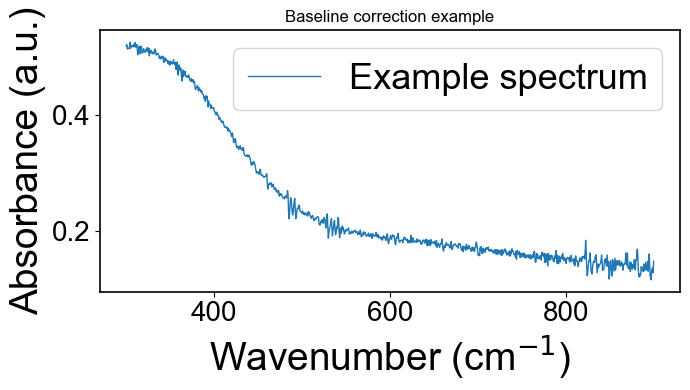

In [17]:
# Baseline correction
    

# We are not going to do baseline correction because a BaSO4 background was already subtracted during data collection.
plt.figure(figsize=(7,4))
plt.plot(spectra[0].frequencies, spectra[0].intensities, label="Example spectrum")

plt.xlabel("Wavenumber (cm$^{-1}$)")
plt.ylabel("Absorbance (a.u.)")
plt.title("Baseline correction example")
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\alw7s\Git\PyMESpec\src\core_functionality\phase.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  self._phase_shift[:, i] = phases_data


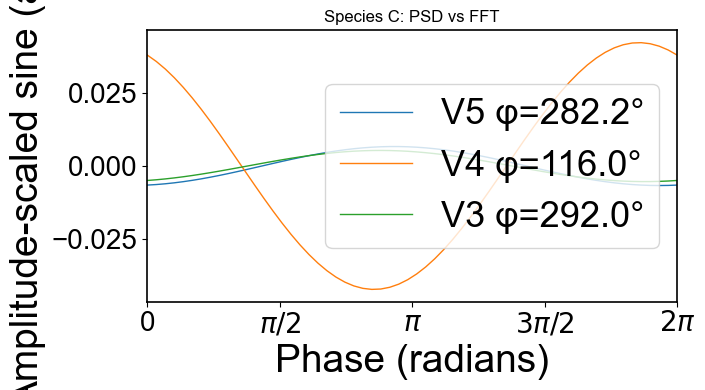

In [18]:

# ==Phase sensitive Detection Section: 
# plot the phases of the different species using the fundamental harmonic.

harmonic_of_interest = 1  # Change this to the harmonic you want to analyze
# These are the frequencies of the species in the synthetic data
frequency_interest_V5 = 425
frequency_interest_V4 = 650
frequency_interest_V3 = 390


phase = Phase(spectra, num_time_points=data_per_pulse)
phase_out = phase.fourier_transform_on_avg_data(harmonic=harmonic_of_interest)


amp_fft_V5, phi_fft_V5 = phase.fft_harmonic_amp_phase_sin_PSD(frequency=frequency_interest_V5, harmonic=harmonic_of_interest)
amp_fft_V4, phi_fft_V4 = phase.fft_harmonic_amp_phase_sin_PSD(frequency=frequency_interest_V4, harmonic=harmonic_of_interest)
amp_fft_V3, phi_fft_V3 = phase.fft_harmonic_amp_phase_sin_PSD(frequency=frequency_interest_V3, harmonic=harmonic_of_interest)

# Overlay
psi = np.linspace(0, 2*np.pi, data_per_pulse)
plt.figure(figsize=(7,4))
plt.plot(psi, amp_fft_V5 * np.sin(psi + phi_fft_V5), label=f"V5 φ={np.degrees(phi_fft_V5):.1f}°")
plt.plot(psi, amp_fft_V4 * np.sin(psi + phi_fft_V4), label=f"V4 φ={np.degrees(phi_fft_V4):.1f}°")
plt.plot(psi, amp_fft_V3 * np.sin(psi + phi_fft_V3), label=f"V3 φ={np.degrees(phi_fft_V3):.1f}°")
plt.xlabel("Phase (radians)")
plt.ylabel("Amplitude-scaled sine (a.u.)")
plt.title("Species C: PSD vs FFT")
plt.xlim(0, 2*np.pi)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
plt.legend()
plt.tight_layout()





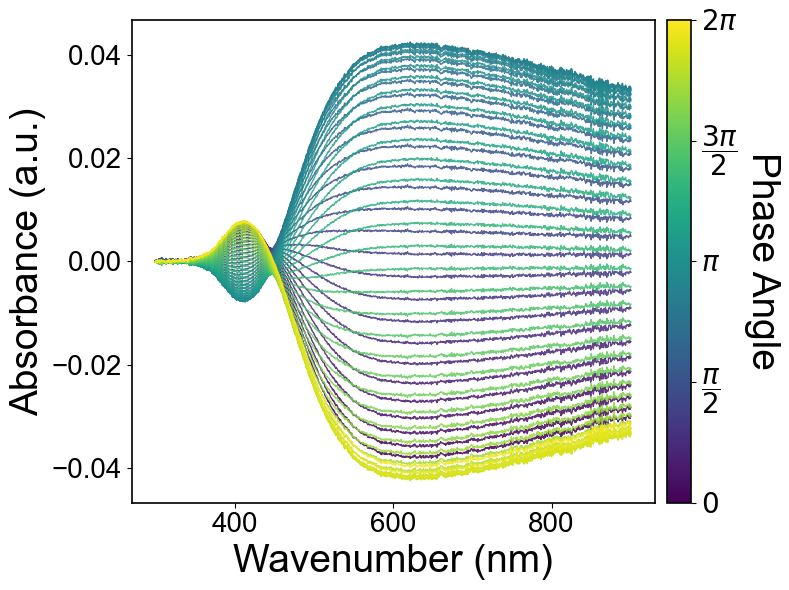

In [19]:
# Plot the sinusoidal phase domain spectra. You can adjust the sampling factor for visualization.
phase_out.plot_sinusodial_PD_spectra(sample_factor=1)

In [20]:
print(spectra[0].frequencies[-1])
print(spectra_ref[0].frequencies[-1])
# since the last frequency of the reference spectra is less than that of the main spectra, we need to adjust the spectral range
spectra = data_processor.spectra.isolate_spectra_sections(frequency_sections=[(spectral_coordinate_start, spectral_coordinate_end_ref)])

900.0
699.77


Text(0, 0.5, 'Site Fraction (a.u.)')

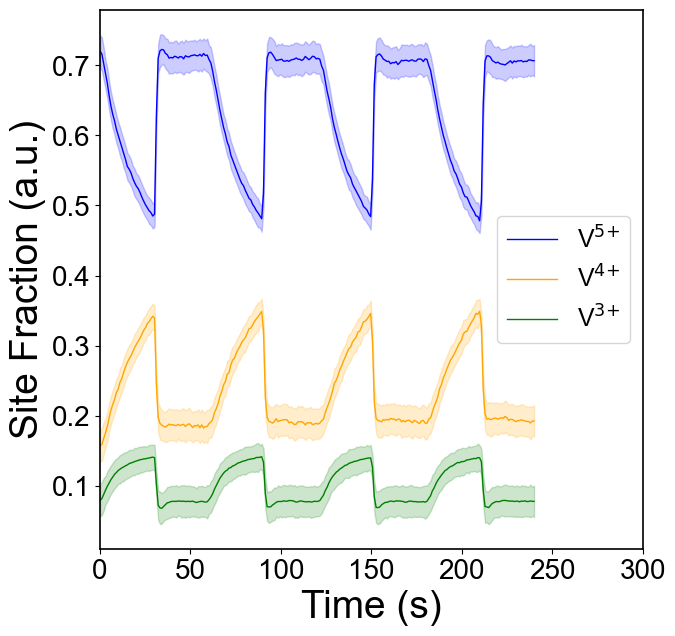

In [21]:
# Chemometrics: lets just look at the first 5 pulses to keep it quick
# plot the deconvoluted fractions for the first 5 pulses
number_of_pulses_to_use = 4
spectra_first_5_pulses = spectra[:data_per_pulse*number_of_pulses_to_use]

chemo = Chemometrics(spectra_ref)
associated_std = np.array([0.01, 0.01, 0.01])  # The standard deviations for each reference spectrum (there is uncertainty in the references that we can propagate)
simple_chemo_spectra, results = chemo.compute_spectra_fitting_as_spectra(spectra_first_5_pulses, normalize_fit=False, ci_mode="bootstrap", spectra_standard_deviations=associated_std,alpha=0.05) 
species_v3plus_conc = [result[FIT_PARAMETERS][0] for result in results]
species_v4_conc = [result[FIT_PARAMETERS][1] for result in results]
species_v5_conc = [result[FIT_PARAMETERS][2] for result in results]

species_v3plus_upper = [result[CONFIDENCE_INTERVALS][0][0] for result in results]
species_v3plus_lower = [result[CONFIDENCE_INTERVALS][0][1] for result in results]
species_v4_upper = [result[CONFIDENCE_INTERVALS][1][0] for result in results]
species_v4_lower = [result[CONFIDENCE_INTERVALS][1][1] for result in results]
species_v5_upper = [result[CONFIDENCE_INTERVALS][2][0] for result in results]
species_v5_lower = [result[CONFIDENCE_INTERVALS][2][1] for result in results]


plt.figure(figsize=(7,7))
t = np.linspace(0, data_per_pulse*collection_dt*number_of_pulses_to_use, data_per_pulse*number_of_pulses_to_use)


plt.plot(t, species_v5_conc, label=r'V$^{5\!+}$', color='blue', linestyle='-')
plt.plot(t, species_v4_conc, label=r'V$^{4\!+}$', color='orange', linestyle='-')
plt.plot(t, species_v3plus_conc, label=r'V$^{3\!+}$', color='green', linestyle='-')

# Plot confidence intervals as shaded regions
plt.fill_between(t, species_v5_lower, species_v5_upper, color='blue', alpha=0.2)
plt.fill_between(t, species_v4_lower, species_v4_upper, color='orange', alpha=0.2)
plt.fill_between(t, species_v3plus_lower, species_v3plus_upper, color='green', alpha=0.2)   
plt.xlim(0,300)
plt.legend(fontsize=18)
plt.xlabel("Time (s)")
plt.ylabel("Site Fraction (a.u.)")

c:\Users\alw7s\Git\PyMESpec\src\core_functionality\rate_data.py:256: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


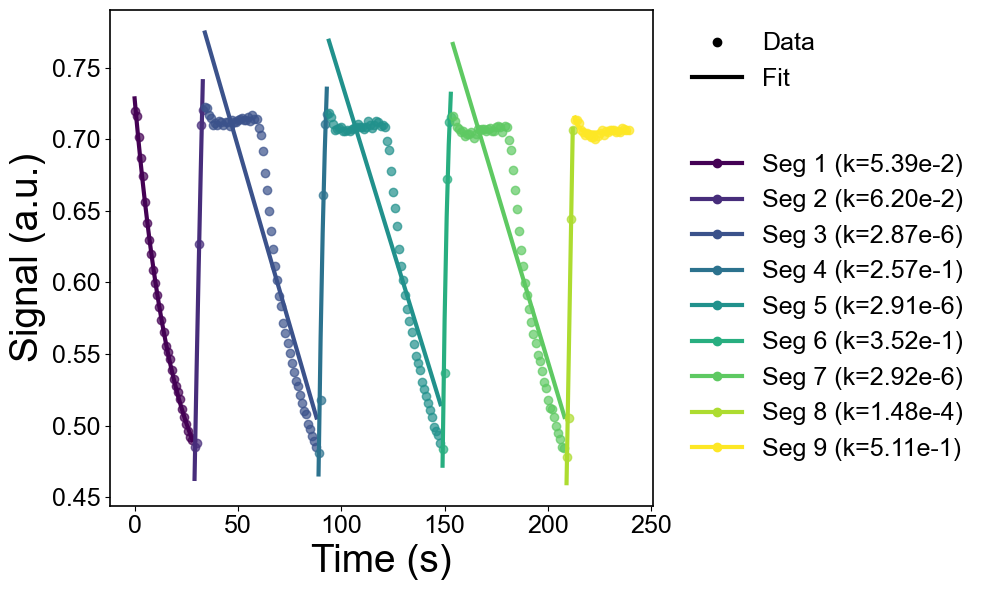

In [22]:

# Now that we have done the chemometrics we can do rate analysis on the deconvoluted data.
# This is an alternative approach instead of just doing it on the spectra directly.
# You need to plot the rate data for the V5 species. See if you need adaptive fitting.

rate_data = RateData(simple_chemo_spectra, time_step_in_seconds=collection_dt)
output_dict_species_V3 = rate_data.compute_all_rate_data_single_freq(select_frequency=0, num_time_points=data_per_pulse)
output_dict_species_V4 = rate_data.compute_all_rate_data_single_freq(select_frequency=1, num_time_points=data_per_pulse)
output_dict_species_V5 = rate_data.compute_all_rate_data_single_freq(select_frequency=2, num_time_points=data_per_pulse)

output = rate_data.plot_decays_and_fits(**output_dict_species_V5, title="Species V5")


c:\Users\alw7s\Git\PyMESpec\src\core_functionality\rate_data.py:540: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_curr, _ = curve_fit(fitting_function, x_curr, new_curr, maxfev=5000)
c:\Users\alw7s\Git\PyMESpec\src\core_functionality\rate_data.py:509: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_curr, _ = curve_fit(fitting_function, x_curr, new_curr, maxfev=5000)


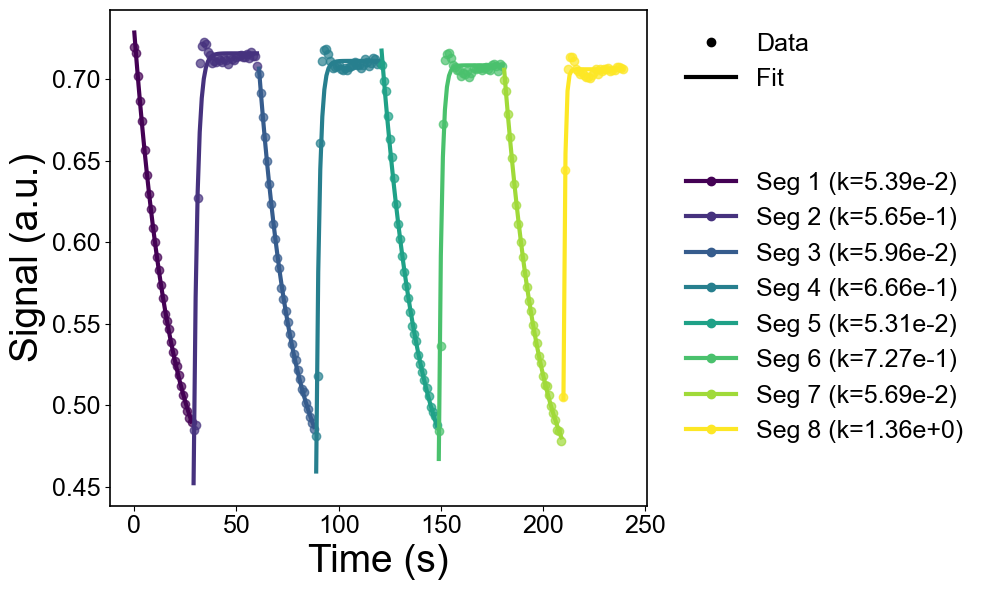

In [23]:
output_dict_species_V5_adaptive = rate_data.compute_all_rate_data_single_freq(select_frequency=2, num_time_points=data_per_pulse, adaptive_fitting=True, max_segments=number_of_pulses_to_use*2, adaptive_swapping_fraction=0.5)
output = rate_data.plot_decays_and_fits(**output_dict_species_V5_adaptive, title="Species V5 Adaptive")

In [24]:
print("done")

done
